In [24]:
import numpy as np
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import random

np.random.seed(42)
random.seed(42)

In [2]:
data = []
labels = []

for subject_dir in sorted(Path("archive").glob("s*"), key=lambda p: int(p.name[1:])):
    label = int(subject_dir.name[1:])
    for img_path in sorted(subject_dir.glob("*.pgm"), key=lambda p: int(p.stem)):
        img = imageio.imread(img_path)
        data.append(img.flatten())
        labels.append(label)


data_matrix = np.array(data)
label_vector = np.array(labels)

/tmp/ipykernel_53962/1647982494.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [3]:
train_data = data_matrix[::2]  # Start = 0, Step = 2
test_data = data_matrix[1::2]  # Start = 1, Step = 2

train_labels = label_vector[::2]  # Start = 0, Step = 2
test_labels = label_vector[1::2]  # Start = 1, Step = 2


In [ ]:
data_centered = data_matrix - np.mean(data_matrix, axis=0)
cov_matrix = np.cov(data_centered, rowvar=False)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Save eigenvalues to file
np.savez('eigenvalues_eigenvectors.npz', eigenvalues=eigenvalues, eigenvectors=eigenvectors)

In [4]:
class PCA:
    def __init__(self, eigenvalues=None, eigenvectors=None,  n_components=None, variance_threshold=None):
        self.n_components = n_components
        self.variance_threshold = variance_threshold
        self.components = None
        self.eigenvalues = eigenvalues
        self.eigenvectors = eigenvectors
        self.mean = None 
        self.explained_variance_ratio = None
    
    def fit(self, X):        
        idx = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idx]
        self.eigenvectors = self.eigenvectors[:, idx]
        
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        
        if self.variance_threshold:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            n_components = np.searchsorted(cumulative_variance, self.variance_threshold) + 1
            self.n_components = min(n_components, X.shape[1])
        elif self.n_components is None:
            self.n_components = X.shape[1]
        
        self.components = self.eigenvectors[:, :self.n_components]
        
        return self
    
    def transform(self, X):
        X_centered = X - self.mean
        
        X_transformed = np.dot(X_centered, self.components)
        
        return X_transformed
    
    def inverse_transform(self, X_transformed):
        X_reconstructed = np.dot(X_transformed, self.components.T) + self.mean
        
        return X_reconstructed

Retained components: 44


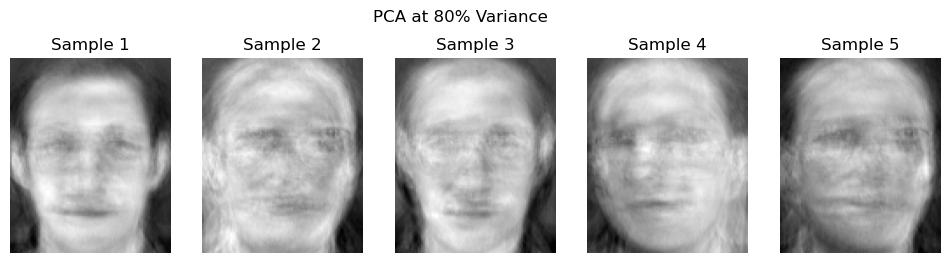

Retained components: 68


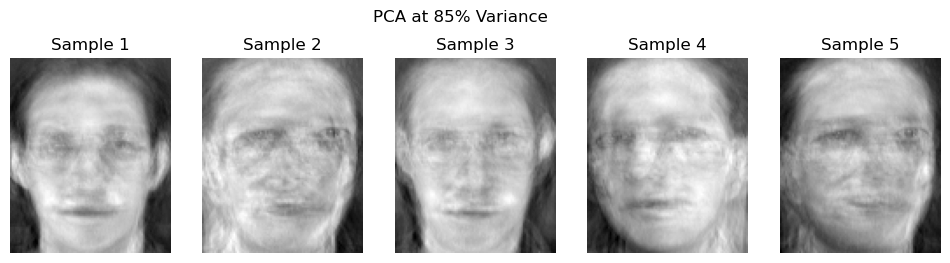

Retained components: 111


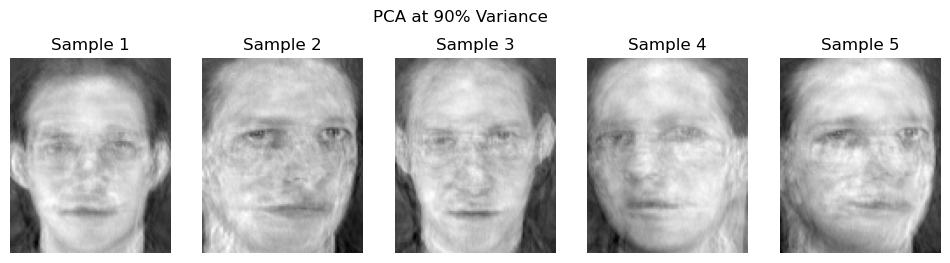

Retained components: 190


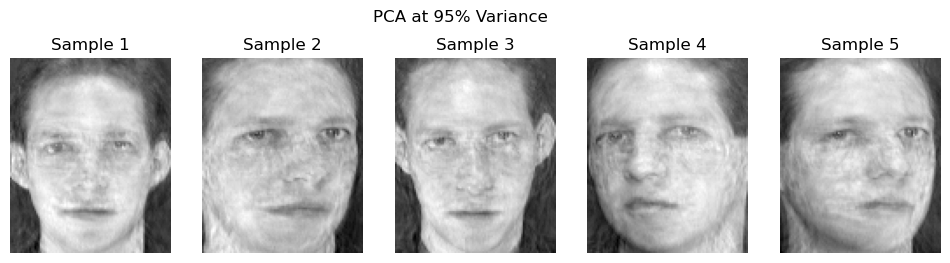

In [5]:
data = np.load('eigenvalues_eigenvectors.npz')

evalues = data['eigenvalues']
evectors = data['eigenvectors']

alphas_values = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas_values :
    pca = PCA(eigenvalues=evalues, eigenvectors=evectors, variance_threshold=alpha)

    pca.mean = np.mean(data_matrix, axis=0)
    pca.fit(data_matrix)

    print(f"Retained components: {pca.n_components}")
    
    train_pca = pca.transform(data_matrix)

    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i, ax in enumerate(axes):
        img = train_pca[i].reshape(1, -1)
        reconstructed = pca.inverse_transform(img).reshape(112, 92)
        ax.imshow(reconstructed, cmap='gray')
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')
    plt.suptitle(f"PCA at {alpha*100:.0f}% Variance")
    plt.show()

In [6]:
class KMeans:
    def __init__(self, n_clusters, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = None
        self.centroids = None
        self.labels = None
    
    def fit(self, X):
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[idx]
        
        for _ in range(self.max_iters):
            distances = self._calculate_distances(X)
            new_labels = np.argmin(distances, axis=1)
            
            if hasattr(self, 'labels') and np.all(self.labels == new_labels):
                break
            
            self.labels = new_labels
            
            for i in range(self.n_clusters):
                points = X[self.labels == i]
                if len(points) > 0:
                    self.centroids[i] = np.mean(points, axis=0)
        
        return self
    
    def predict(self, X):
        distances = self._calculate_distances(X)    
        return np.argmin(distances, axis=1)
    
    def _calculate_distances(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.linalg.norm(X - centroid, axis=1)
        
        return distances

In [7]:
alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20, 40, 60]

# Store results
kmeans_accuracies = {}

for alpha in alphas:
    # Initialize PCA with eigenvalues and eigenvectors
    
    pca = PCA(eigenvalues=evalues, eigenvectors=evectors, variance_threshold=alpha)
    pca.mean = np.mean(train_data, axis=0)
    pca.fit(train_data)

    # Project train data
    X_train_reduced = pca.transform(train_data)
    
    # Create a dictionary for this alpha
    kmeans_accuracies[alpha] = {}
    
    for K in Ks:
        # Apply KMeans
        kmeans = KMeans(n_clusters=K)
        kmeans.fit(X_train_reduced)
        cluster_labels = kmeans.labels
        
        # Map each cluster to the most frequent true label
        mapping = {}
        for cluster in range(K):
            indices = np.where(cluster_labels == cluster)[0]
            if len(indices) == 0:
                continue
            true_labels = train_labels[indices]
            most_common_label = np.bincount(true_labels).argmax()
            mapping[cluster] = most_common_label
        
        # Predict labels using the mapping
        predicted_labels = np.array([mapping[label] for label in cluster_labels])
        
        # Compute clustering accuracy
        accuracy = np.mean(predicted_labels == train_labels)
        kmeans_accuracies[alpha][K] = accuracy
        
        print(f"Alpha={alpha}, K={K}, Accuracy={accuracy:.4f}")



Alpha=0.8, K=20, Accuracy=0.4100
Alpha=0.8, K=40, Accuracy=0.7300
Alpha=0.8, K=60, Accuracy=0.8700
Alpha=0.85, K=20, Accuracy=0.4300
Alpha=0.85, K=40, Accuracy=0.6450
Alpha=0.85, K=60, Accuracy=0.7900
Alpha=0.9, K=20, Accuracy=0.3950
Alpha=0.9, K=40, Accuracy=0.6100
Alpha=0.9, K=60, Accuracy=0.7550
Alpha=0.95, K=20, Accuracy=0.4250
Alpha=0.95, K=40, Accuracy=0.6850
Alpha=0.95, K=60, Accuracy=0.8700


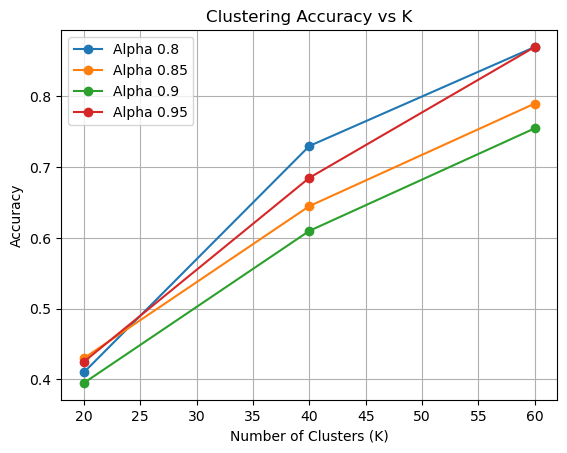

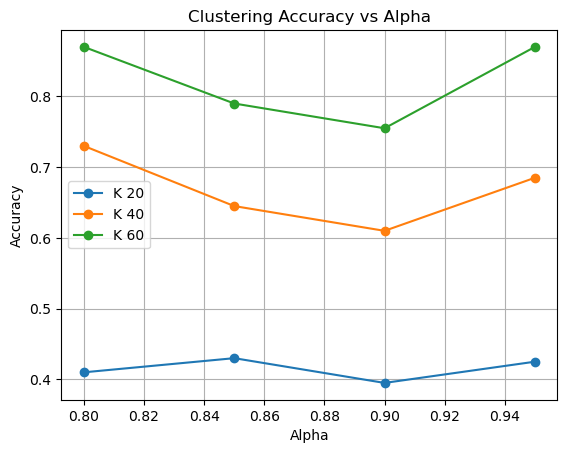

In [8]:
for alpha in alphas:
    Ks_list = list(kmeans_accuracies[alpha].keys())
    acc_list = list(kmeans_accuracies[alpha].values())
    plt.plot(Ks_list, acc_list, marker='o', label=f'Alpha {alpha}')

plt.title('Clustering Accuracy vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy vs Alpha for each K
for K in Ks:
    alpha_list = []
    acc_list = []
    for alpha in alphas:
        alpha_list.append(alpha)
        acc_list.append(kmeans_accuracies[alpha][K])
    plt.plot(alpha_list, acc_list, marker='o', label=f'K {K}')

plt.title('Clustering Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
class GMM:
    def __init__(self, n_components, max_iters=100, tol=1e-4, reg_covar=1e-6):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.reg_covar = reg_covar  # Regularization for covariance matrices
        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.responsibilities_ = None

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # K-means++ initialization for better starting points
        self.means_ = X[np.random.choice(n_samples, self.n_components, replace=False)]
        for i in range(1, self.n_components):
            dists = np.array([np.min([np.linalg.norm(x - c)**2 for c in self.means_[:i]]) for x in X])
            probs = dists / dists.sum()
            self.means_[i] = X[np.random.choice(n_samples, p=probs)]
        
        # Equal weights initially
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        # Initialize covariances as identity matrices
        self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def _compute_log_prob(self, X):
        n_samples, n_features = X.shape
        log_prob = np.empty((n_samples, self.n_components))
        
        for k in range(self.n_components):
            try:
                chol = np.linalg.cholesky(self.covariances_[k])
            except np.linalg.LinAlgError:
                self.covariances_[k] += np.eye(n_features) * self.reg_covar
                chol = np.linalg.cholesky(self.covariances_[k])
                
            log_det = 2 * np.sum(np.log(np.diagonal(chol)))
            diff = X - self.means_[k]
            sol = np.linalg.solve(chol, diff.T).T
            log_prob[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_det + 
                                    np.sum(sol**2, axis=1))
            
        return log_prob + np.log(self.weights_)

    def _e_step(self, X):
        log_prob_norm = self._compute_log_prob(X)
        log_resp = log_prob_norm - logsumexp(log_prob_norm, axis=1, keepdims=True)
        self.responsibilities_ = np.exp(log_resp)
        return np.mean(log_prob_norm.max(axis=1))

    def _m_step(self, X):
        n_samples, _ = X.shape
        resp = self.responsibilities_
        
        # Update weights
        self.weights_ = resp.sum(axis=0) / n_samples
        
        # Update means
        self.means_ = np.dot(resp.T, X) / resp.sum(axis=0)[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = (resp[:, k] * diff.T) @ diff / resp[:, k].sum()
            self.covariances_[k] += np.eye(X.shape[1]) * self.reg_covar

    def fit(self, X):
        self._initialize_parameters(X)
        prev_lower_bound = -np.inf
        
        for iteration in range(self.max_iters):
            # E-step
            lower_bound = self._e_step(X)
            
            # Check convergence
            if abs(lower_bound - prev_lower_bound) < self.tol:
                break
            prev_lower_bound = lower_bound
            
            # M-step
            self._m_step(X)
            
        return self

    def predict(self, X):
        log_prob = self._compute_log_prob(X)
        return np.argmax(log_prob, axis=1)

    def predict_proba(self, X):
        log_prob = self._compute_log_prob(X)
        return np.exp(log_prob - logsumexp(log_prob, axis=1, keepdims=True))

In [26]:
alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20, 40, 60]

gmm_accuracies = {}

for alpha in alphas:
    pca = PCA(eigenvalues=evalues, eigenvectors=evectors, variance_threshold=alpha)
    pca.mean = np.mean(train_data, axis=0)
    pca.fit(train_data)

    X_train_reduced = pca.transform(train_data)

    gmm_accuracies[alpha] = {}

    for K in Ks:
        gmm = GMM(n_components=K)
        gmm.fit(X_train_reduced)
        cluster_labels = gmm.predict(X_train_reduced)

        # Map clusters to majority true labels
        mapping = {}
        for cluster in range(K):
            indices = np.where(cluster_labels == cluster)[0]
            if len(indices) == 0:
                continue
            true_labels = train_labels[indices]
            most_common_label = np.bincount(true_labels).argmax()
            mapping[cluster] = most_common_label

        predicted_labels = np.array([mapping[label] for label in cluster_labels])

        accuracy = np.mean(predicted_labels == train_labels)
        gmm_accuracies[alpha][K] = accuracy

        print(f"[GMM] Alpha={alpha}, K={K}, Accuracy={accuracy:.4f}")


[GMM] Alpha=0.8, K=20, Accuracy=0.3950
[GMM] Alpha=0.8, K=40, Accuracy=0.6400
[GMM] Alpha=0.8, K=60, Accuracy=0.8000
[GMM] Alpha=0.85, K=20, Accuracy=0.4500
[GMM] Alpha=0.85, K=40, Accuracy=0.6150
[GMM] Alpha=0.85, K=60, Accuracy=0.8250
[GMM] Alpha=0.9, K=20, Accuracy=0.4100
[GMM] Alpha=0.9, K=40, Accuracy=0.6550
[GMM] Alpha=0.9, K=60, Accuracy=0.7800
[GMM] Alpha=0.95, K=20, Accuracy=0.3300
[GMM] Alpha=0.95, K=40, Accuracy=0.6000
[GMM] Alpha=0.95, K=60, Accuracy=0.7550


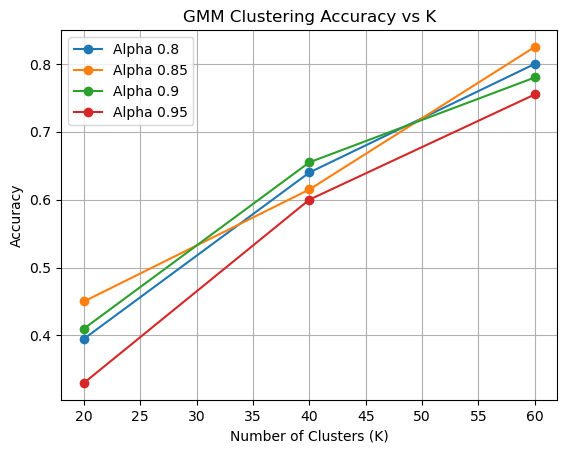

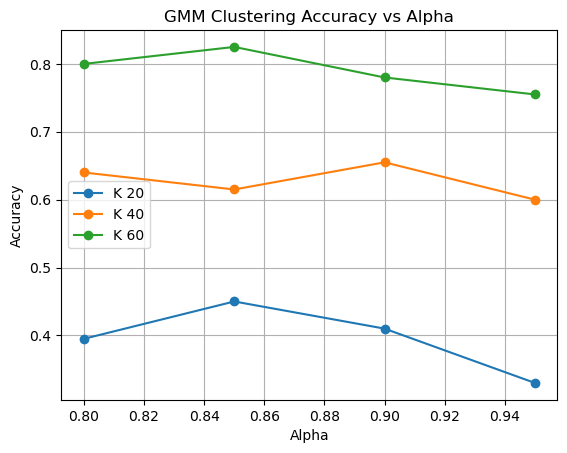

In [27]:
# Plot Accuracy vs K for each Alpha
for alpha in alphas:
    Ks_list = list(gmm_accuracies[alpha].keys())
    acc_list = list(gmm_accuracies[alpha].values())
    plt.plot(Ks_list, acc_list, marker='o', label=f'Alpha {alpha}')

plt.title('GMM Clustering Accuracy vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy vs Alpha for each K
for K in Ks:
    alpha_list = []
    acc_list = []
    for alpha in alphas:
        alpha_list.append(alpha)
        acc_list.append(gmm_accuracies[alpha][K])
    plt.plot(alpha_list, acc_list, marker='o', label=f'K {K}')

plt.title('GMM Clustering Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
